In [1]:
import pandas as pd

In [57]:
df = pd.read_parquet('data\Austria_Inflation_(CPI).parquet')
df = df.set_index('Year')
df.index = pd.to_datetime(df.index, format='%Y').strftime('%Y')
df.index = pd.to_datetime(df.index, format='%Y')
df = df.drop('Indicator', axis = 1)
df = df.dropna()
df.head()

,Value
Year,
1960-01-01,1.945749
1961-01-01,3.542240
1962-01-01,4.381799
1963-01-01,2.708767
1964-01-01,3.868564


In [58]:
df.index

DatetimeIndex(['1960-01-01', '1961-01-01', '1962-01-01', '1963-01-01',
               '1964-01-01', '1965-01-01', '1966-01-01', '1967-01-01',
               '1968-01-01', '1969-01-01', '1970-01-01', '1971-01-01',
               '1972-01-01', '1973-01-01', '1974-01-01', '1975-01-01',
               '1976-01-01', '1977-01-01', '1978-01-01', '1979-01-01',
               '1980-01-01', '1981-01-01', '1982-01-01', '1983-01-01',
               '1984-01-01', '1985-01-01', '1986-01-01', '1987-01-01',
               '1988-01-01', '1989-01-01', '1990-01-01', '1991-01-01',
               '1992-01-01', '1993-01-01', '1994-01-01', '1995-01-01',
               '1996-01-01', '1997-01-01', '1998-01-01', '1999-01-01',
               '2000-01-01', '2001-01-01', '2002-01-01', '2003-01-01',
               '2004-01-01', '2005-01-01', '2006-01-01', '2007-01-01',
               '2008-01-01', '2009-01-01', '2010-01-01', '2011-01-01',
               '2012-01-01', '2013-01-01', '2014-01-01', '2015-01-01',
      

<Axes: xlabel='Lag', ylabel='Autocorrelation'>

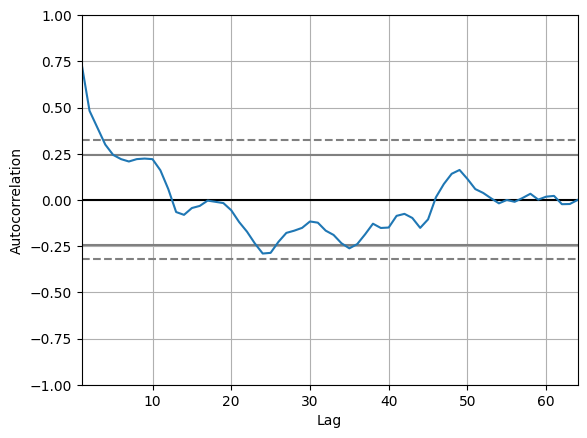

In [59]:

from pandas.plotting import lag_plot , autocorrelation_plot

autocorrelation_plot(df)

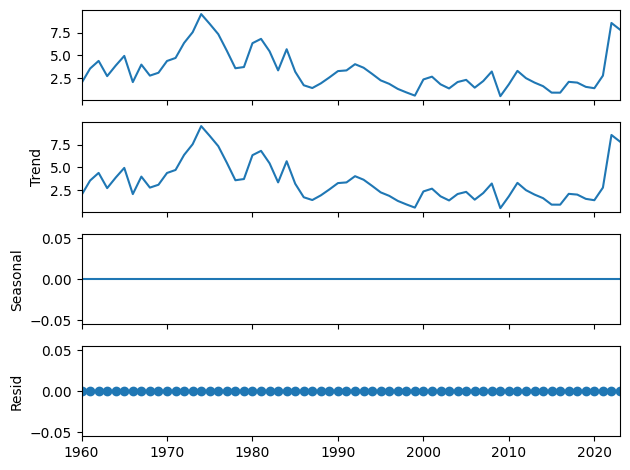

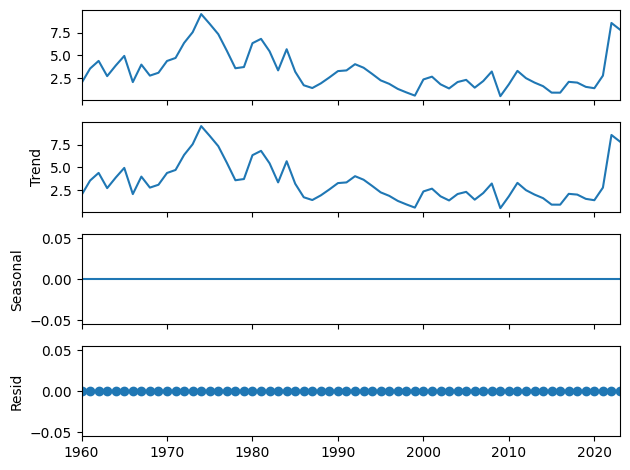

In [60]:
from statsmodels.tsa.seasonal import seasonal_decompose
result = seasonal_decompose(df, model='additive' , period=1)
result.plot()


In [1]:

import os
import json
import pandas as pd
import xgboost as xgb
from statsmodels.tsa.arima.model import ARIMA
from prophet import Prophet
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import GridSearchCV
import numpy as np


def train_xgboost(train_x, train_y, test_x, test_y):
    param_grid = {
        'n_estimators': [50, 100, 200],
        'learning_rate': [0.01, 0.05, 0.1],
        'max_depth': [3, 5]
    }
    model = xgb.XGBRegressor(objective='reg:squarederror')
    grid_search = GridSearchCV(model, param_grid, cv=3, scoring='neg_mean_squared_error')
    grid_search.fit(train_x, train_y)
    best_model = grid_search.best_estimator_
    predictions = best_model.predict(test_x)
    return np.sqrt(mean_squared_error(test_y, predictions))


def train_arima(train_y, test_y):
    best_rmse = float('inf')
    best_order = None
    
    for p in range(4):
        for d in range(4):
            for q in range(4):
                try:
                    model = ARIMA(train_y, order=(p, d, q))
                    model_fit = model.fit()
                    predictions = model_fit.forecast(steps=len(test_y))
                    rmse = np.sqrt(mean_squared_error(test_y, predictions))
                    if rmse < best_rmse:
                        best_rmse = rmse
                        best_order = (p, d, q)
                except:
                    continue
    return best_rmse


from prophet.diagnostics import cross_validation, performance_metrics

def train_prophet(train_df, test_y):
    param_grid = {
        'changepoint_prior_scale': [0.01, 0.1, 0.5],  # Controls trend flexibility
        'seasonality_mode': ['additive', 'multiplicative'],  # Mode of seasonality
    }

    best_rmse = float('inf')
    best_params = None

    for changepoint_prior in param_grid['changepoint_prior_scale']:
        for seasonality_mode in param_grid['seasonality_mode']:
            model = Prophet(
                yearly_seasonality=True,
                weekly_seasonality=False,
                daily_seasonality=False,
                changepoint_prior_scale=changepoint_prior,
                seasonality_mode=seasonality_mode
            )
            model.fit(train_df)

            future = model.make_future_dataframe(periods=len(test_y), freq='Y')
            forecast = model.predict(future)
            predictions = forecast['yhat'].iloc[-len(test_y):].values
            rmse = np.sqrt(mean_squared_error(test_y, predictions))

            if rmse < best_rmse:
                best_rmse = rmse
                best_params = (changepoint_prior, seasonality_mode)

    # Train best model
    best_model = Prophet(
        yearly_seasonality=True,
        weekly_seasonality=False,
        daily_seasonality=False,
        changepoint_prior_scale=best_params[0],
        seasonality_mode=best_params[1]
    )
    best_model.fit(train_df)
    future = best_model.make_future_dataframe(periods=len(test_y), freq='Y')
    forecast = best_model.predict(future)
    predictions = forecast['yhat'].iloc[-len(test_y):].values

    return np.sqrt(mean_squared_error(test_y, predictions))


# Load country and indicator data
with open("countries.json", "r") as f:
    country_names = json.load(f)

with open("indicators.json", "r") as f:
    indicators = json.load(f)

data_folder = "data"
model_errors_rmse = {}
log_data = []

for country, country_code in country_names.items():
    for indicator, indicator_code in indicators.items():
        filename = f"{country.replace(' ', '_')}_{indicator.replace(' ', '_')}.parquet"
        filepath = os.path.join(data_folder, filename)
        
        if os.path.exists(filepath):
            df = pd.read_parquet(filepath)
            if 'Year' in df.columns and 'Value' in df.columns:
                df = df.set_index('Year').sort_index()
                df.index = pd.to_datetime(df.index, format='%Y')
                df = df.dropna()
                train_size = int(len(df) * 0.8)
                train, test = df.iloc[:train_size], df.iloc[train_size:]
                model_errors_rmse[(country, indicator)] = {}
                
                train_x, train_y = np.arange(len(train)).reshape(-1, 1), train['Value'].values
                test_x, test_y = np.arange(len(train), len(df)).reshape(-1, 1), test['Value'].values
                prophet_train_df = train.reset_index().rename(columns={'Year': 'ds', 'Value': 'y'})
                
                model_errors_rmse[(country, indicator)]['XGBoost'] = train_xgboost(train_x, train_y, test_x, test_y)
                model_errors_rmse[(country, indicator)]['ARIMA'] = train_arima(train_y, test_y)
                model_errors_rmse[(country, indicator)]['Prophet'] = train_prophet(prophet_train_df, test_y)
                
                sorted_models = sorted(model_errors_rmse[(country, indicator)].items(), key=lambda x: x[1])
                for rank, (model_name, rmse) in enumerate(sorted_models, start=1):
                    log_data.append([country, indicator, model_name, rmse, rank])

log_df = pd.DataFrame(log_data, columns=['Country', 'Indicator', 'Model', 'RMSE', 'Rank'])
log_df.to_csv("model_error_log.csv", index=False)


c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
c:\Users\admin\Desktop\diplomovka\Code\Model_staff\myenv\lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros 

In [4]:
log_df.loc[log_df['Indicator']=="Inflation (CPI)",:]

,Country,Indicator,Model,RMSE,Rank
6,Czech Republic,Inflation (CPI),ARIMA,3.068765,1
7,Czech Republic,Inflation (CPI),XGBoost,6.860266,2
8,Czech Republic,Inflation (CPI),Prophet,7.188270,3
27,Hungary,Inflation (CPI),ARIMA,4.543801,1
28,Hungary,Inflation (CPI),XGBoost,5.581490,2
29,Hungary,Inflation (CPI),Prophet,5.689929,3
48,Poland,Inflation (CPI),Prophet,4.493903,1
49,Poland,Inflation (CPI),ARIMA,4.528208,2
50,Poland,Inflation (CPI),XGBoost,4.741624,3
69,Slovakia,Inflation (CPI),ARIMA,2.499848,1


In [5]:


# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_country_df = log_df.pivot_table(index=['Country', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_country_df.columns = ['1', '2', '3']

# Reset index for clear visibility
pivot_country_df.reset_index(inplace=True)
pivot_country_df.to_csv("model_rankings_by_country_with_models.csv", index=False)

pivot_country_df

,Country,Model,1,2,3
0,Austria,ARIMA,5,2,0
1,Austria,Prophet,1,4,2
2,Austria,XGBoost,1,1,5
3,Czech Republic,ARIMA,6,1,0
4,Czech Republic,Prophet,1,2,4
5,Czech Republic,XGBoost,0,4,3
6,France,ARIMA,5,2,0
7,France,Prophet,2,3,2
8,France,XGBoost,0,2,5
9,Germany,ARIMA,7,0,0


In [6]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
pivot_df = log_df.pivot_table(index=['Indicator', 'Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
pivot_df.columns = ['1', '2', '3']

# Reset index for clear visibility
pivot_df.reset_index(inplace=True)
pivot_df.to_csv("model_rankings_by_indicator_with_models.csv", index=False)

pivot_df

,Indicator,Model,1,2,3
0,Exports of goods and services (% of GDP),ARIMA,5,3,0
1,Exports of goods and services (% of GDP),Prophet,3,1,4
2,Exports of goods and services (% of GDP),XGBoost,0,4,4
3,GDP (USD),ARIMA,7,1,0
4,GDP (USD),Prophet,1,5,2
5,GDP (USD),XGBoost,0,2,6
6,GDP growth (annual %),ARIMA,8,0,0
7,GDP growth (annual %),Prophet,0,5,3
8,GDP growth (annual %),XGBoost,0,3,5
9,GDP per Capita (USD),ARIMA,6,2,0


In [7]:
# Create the pivot DataFrame, where rows are indicator-model pairs, and columns are the ranks (1, 2, 3)
overall_df = log_df.pivot_table(index=['Model'], 
                              columns='Rank', 
                              aggfunc='size', 
                              fill_value=0)

# Rename columns to reflect the rank (1, 2, 3)
overall_df.columns = ['1', '2', '3']

# Reset index for clear visibility
overall_df.reset_index(inplace=True)
overall_df.to_csv("model_rankings_overall_placements.csv", index=False)

overall_df

,Model,1,2,3
0,ARIMA,45,11,0
1,Prophet,10,26,20
2,XGBoost,1,19,36
